# Automated Detection of Pneumonia Using a Hybrid CNN-Transformer Model

## CNN Model

### Cell 1: Install Necessary Libraries
This cell installs all required libraries for the project, including `monai`, `torch`, `torchvision`, `medmnist`, and `matplotlib`. These libraries are essential for data processing, model building, evaluation, and visualization tasks.

In [1]:
# Install necessary libraries
!pip install monai torch torchvision medmnist matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.7 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=b20ace1aa5d4eb83a544b93a10f92e8d758bf6ea2bd7823b4df9aaf5dad90a9c
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


### Cell 2: Import Libraries
This cell imports the libraries and modules needed for the project. It includes `torch` and `torch.nn` for PyTorch-based model building, `matplotlib.pyplot` for visualizations, and various `monai` and `torchvision` modules for data transformations. The `medmnist` library provides the `PneumoniaMNIST` dataset, and `sklearn.metrics` enables evaluation metrics.

In [2]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import seaborn as sns
import numpy as np
from monai.transforms import (LoadImage, EnsureChannelFirst, ScaleIntensity, Resize, RandRotate90, ToTensor, Compose)
from monai.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from medmnist import PneumoniaMNIST
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score

### Cell 3: Check Device Availability
This cell checks if a CUDA-compatible GPU is available. If so, it sets the device to GPU for faster computations; otherwise, it defaults to the CPU.

In [3]:
# Check device (CUDA or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Cell 4: Define Data Transformations
This cell sets up data preprocessing transformations using `torchvision.transforms`. The transformations include resizing, converting images to tensors, and normalizing pixel values to [-1, 1], preparing the data for input into the neural network.

In [4]:
# Data Preprocessing
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to match the input size expected by ResNet
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to range [-1, 1]
])

val_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

### Cell 5: Download and Load the Dataset
In this cell, the `PneumoniaMNIST` dataset is downloaded and loaded. It applies the defined transformations to the training and validation sets and creates data loaders for batching and shuffling data.

In [5]:
# Download and load dataset
train_dataset = PneumoniaMNIST(split='train', download=True, as_rgb=False, transform=train_transforms)
val_dataset = PneumoniaMNIST(split='val', download=True, as_rgb=False, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

100%|██████████| 4.17M/4.17M [00:00<00:00, 5.36MB/s]


Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


### Cell 6: Define the CNN Model
This cell defines the CNN model using a ResNet18 backbone. The model is adapted for grayscale images by modifying the input layer, and a custom fully connected layer is added for binary classification (pneumonia vs. healthy).

In [6]:
# CNN Model Definition using ResNet18
class PneumoniaCNN(nn.Module):
    def __init__(self):
        super(PneumoniaCNN, self).__init__()
        self.backbone = resnet18(weights='IMAGENET1K_V1')  # Update for PyTorch > 0.13
        self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.backbone.fc = nn.Identity()  # Remove fully connected layer
        self.fc = nn.Linear(512, 2)  # Binary classification (pneumonia vs. healthy)

    def forward(self, x):
        x = self.backbone(x)
        return self.fc(x)

### Cell 7: CNN - Initialize Model, Loss Function, and Optimizer
This cell initializes the CNN model and specifies the cross-entropy loss function for binary classification. It also sets up the Adam optimizer with a learning rate and weight decay for training the model.

In [7]:
# Initialize model, loss function, and optimizer
model = PneumoniaCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 133MB/s]


### Cell 8: Training Function & Validation Function
This cell defines the training function `train_epoch`, which trains the model for one epoch. It performs a forward pass, computes the loss, and updates the model’s weights using backpropagation. This cell also defines the validation function `val_epoch`. It evaluates the model on the validation dataset, computes metrics such as accuracy, precision, recall, F1 score, and ROC-AUC, and returns the average validation loss and these metrics.

In [8]:
# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.view(-1).long().to(device)
        optimizer.zero_grad()

        # Check if the model output is a tuple
        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # Only keep the primary output

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(train_loader.dataset)

# Validation function
def val_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.view(-1).long().to(device)

            # Check if the model output is a tuple
            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # Only keep the primary output

            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    roc_auc = roc_auc_score(all_labels, all_probs)
    accuracy = np.mean(all_preds == all_labels)

    return running_loss / len(val_loader.dataset), accuracy, precision, recall, f1, roc_auc

### Cell 9: Metrics Plot Function
This cell defines a function `plot_metrics` to visualize training and validation losses, as well as other validation metrics (accuracy, precision, recall, F1, ROC-AUC) across epochs. It creates multiple line plots for tracking model performance over time.

In [9]:
# Plotting function for metrics
def plot_metrics(train_losses, val_losses, val_accuracies, val_precisions, val_recalls, val_f1s, val_roc_aucs):
    epochs = range(1, len(train_losses) + 1)

    # Loss plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Accuracy plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Precision, Recall, F1, and ROC-AUC plots
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, val_precisions, label="Precision")
    plt.plot(epochs, val_recalls, label="Recall")
    plt.plot(epochs, val_f1s, label="F1 Score")
    plt.plot(epochs, val_roc_aucs, label="ROC-AUC")
    plt.title("Validation Metrics")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

### Cell 10: Confusion Matrix Plot Function
This cell defines a function `plot_confusion_matrix` that generates and displays a confusion matrix for the validation predictions. It provides insight into the model’s classification accuracy for each class.

In [13]:
# Confusion Matrix Plot
def plot_confusion_matrix(val_loader, model, device):
    all_preds = []
    all_labels = []
    model.eval()

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.view(-1).long().to(device)

            # Modify this line to accept all outputs from the model
            outputs = model(images)

            # If model outputs is a tuple or list, and the predictions (logits) are the first element
            if isinstance(outputs, (tuple, list)):
                outputs = outputs[0]

            # Use only the predictions for the confusion matrix
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

### Cell 11: CNN - Training Loop
In this cell, a training loop is defined to train the model for a specified number of epochs. During each epoch, the model is trained, and then validated. The cell logs training and validation losses and metrics for each epoch.

In [11]:
# Training loop
num_epochs = 50
train_losses, val_losses, val_accuracies = [], [], []
val_precisions, val_recalls, val_f1s, val_roc_aucs = [], [], [], []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, val_precision, val_recall, val_f1, val_roc_auc = val_epoch(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, "
          f"F1: {val_f1:.4f}, ROC-AUC: {val_roc_auc:.4f}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)
    val_roc_aucs.append(val_roc_auc)

Epoch 1/50, Train Loss: 0.1650, Val Loss: 0.0905, Val Accuracy: 0.9676, Precision: 0.9819, Recall: 0.9743, F1: 0.9781, ROC-AUC: 0.9946
Epoch 2/50, Train Loss: 0.0500, Val Loss: 0.0899, Val Accuracy: 0.9656, Precision: 0.9673, Recall: 0.9871, F1: 0.9771, ROC-AUC: 0.9961
Epoch 3/50, Train Loss: 0.0393, Val Loss: 0.1387, Val Accuracy: 0.9542, Precision: 0.9815, Recall: 0.9563, F1: 0.9688, ROC-AUC: 0.9929
Epoch 4/50, Train Loss: 0.0293, Val Loss: 0.1081, Val Accuracy: 0.9656, Precision: 0.9818, Recall: 0.9717, F1: 0.9767, ROC-AUC: 0.9955
Epoch 5/50, Train Loss: 0.0384, Val Loss: 0.1067, Val Accuracy: 0.9599, Precision: 0.9554, Recall: 0.9923, F1: 0.9735, ROC-AUC: 0.9943
Epoch 6/50, Train Loss: 0.0346, Val Loss: 0.0595, Val Accuracy: 0.9771, Precision: 0.9821, Recall: 0.9871, F1: 0.9846, ROC-AUC: 0.9976
Epoch 7/50, Train Loss: 0.0099, Val Loss: 0.1558, Val Accuracy: 0.9523, Precision: 0.9439, Recall: 0.9949, F1: 0.9687, ROC-AUC: 0.9943
Epoch 8/50, Train Loss: 0.0093, Val Loss: 0.0896, Val A

### Cell 12: CNN - Plots
This cell calls the `plot_metrics` and `plot_confusion_matrix` functions to display the model’s performance across epochs and the final confusion matrix.

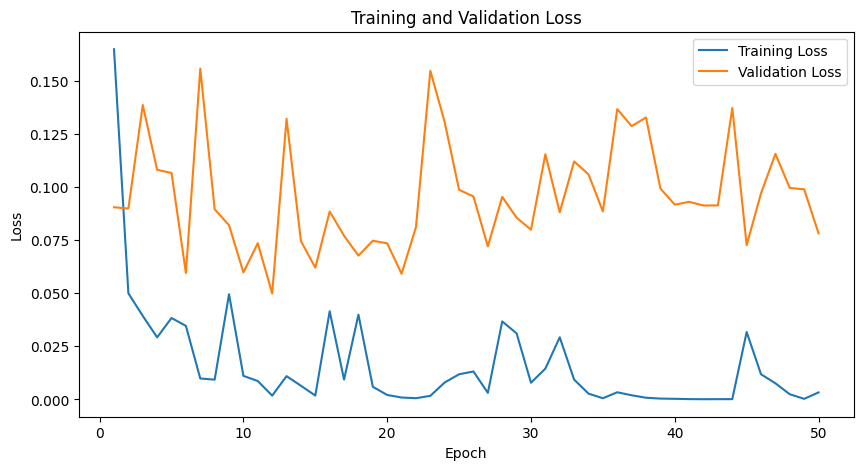

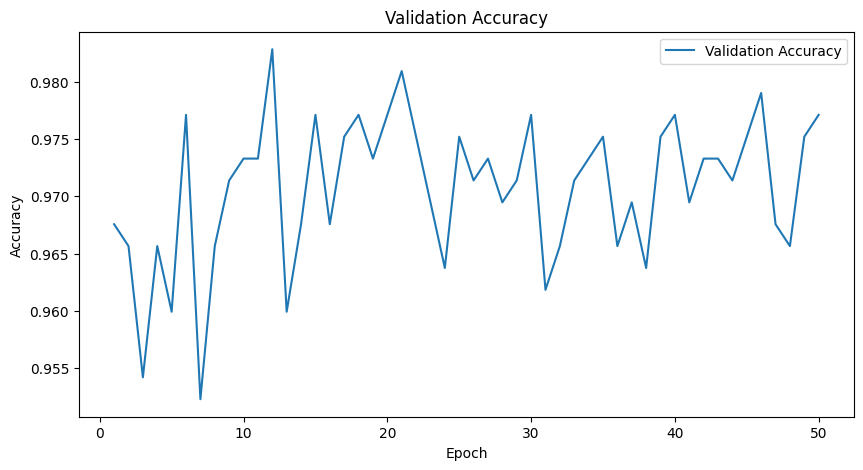

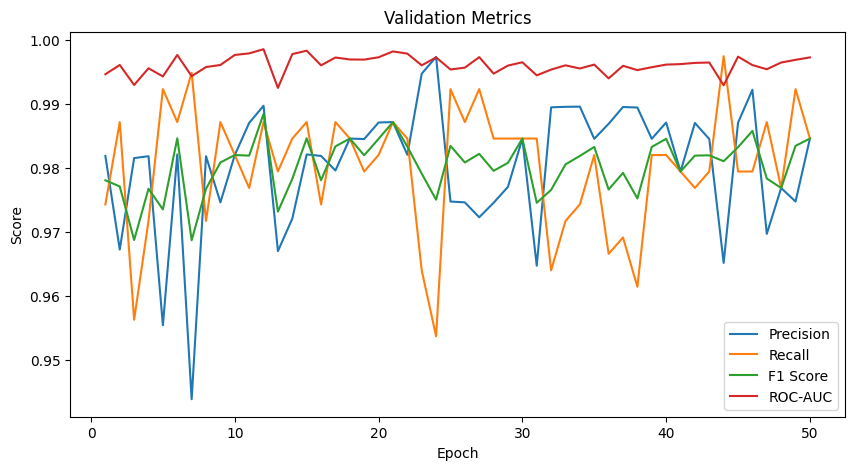

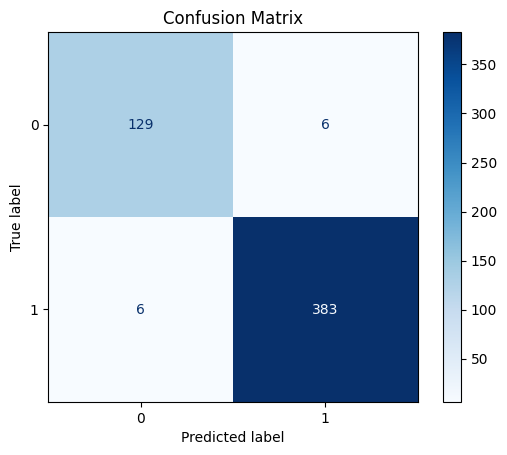

In [14]:
# Plot metrics
plot_metrics(train_losses, val_losses, val_accuracies, val_precisions, val_recalls, val_f1s, val_roc_aucs)

# Plot confusion matrix
plot_confusion_matrix(val_loader, model, device)

# Save the trained model
torch.save(model.state_dict(), "pneumonia_cnn.pth")

## Hybrid Model

### Cell 13: Define the Hybrid Model
This cell defines the hybrid CNN-Transformer model. It uses a CNN backbone based on ResNet18 for local feature extraction and a Transformer encoder for capturing global relationships. The model incorporates positional encoding to retain spatial information across sequences. The final layer is a fully connected layer for binary classification (pneumonia vs. healthy).

In [15]:
# Positional Encoding class
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(1)  # Shape: (max_len, 1, d_model)

    def forward(self, x):
        seq_len, batch_size, d_model = x.size()
        return x + self.encoding[:seq_len, :].to(x.device)

class CustomTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead):
        super(CustomTransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead)
        self.linear1 = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(0.1)
        self.linear2 = nn.Linear(d_model, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)

    def forward(self, x):
        # Get attention output and weights
        attn_output, attn_weights = self.self_attn(x, x, x)
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)
        x = x + self.dropout2(self.linear2(self.dropout(F.relu(self.linear1(x)))))
        x = self.norm2(x)
        return x, attn_weights  # Return attention weights

# Hybrid CNN-Transformer Model with Positional Encoding
class PneumoniaHybridModel(nn.Module):
    def __init__(self):
        super(PneumoniaHybridModel, self).__init__()

        # CNN Backbone
        self.backbone = resnet18(weights='IMAGENET1K_V1')
        self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.backbone.fc = nn.Identity()  # Remove fully connected layer
        self.backbone.avgpool = nn.Identity()  # Remove pooling layer to retain spatial dimensions

        # Optional layer to restore spatial dimensions if needed
        self.conv_restore = nn.Conv2d(512, 512, kernel_size=1)  # Apply only if needed

        # Positional Encoding for Transformer
        self.pos_encoder = PositionalEncoding(d_model=512)

        # Custom Transformer Encoder Layer
        self.transformer_layers = nn.ModuleList(
            [CustomTransformerEncoderLayer(d_model=512, nhead=8) for _ in range(4)]
        )

        # Fully Connected Layer for Classification
        self.fc = nn.Linear(512, 2)  # Binary classification (pneumonia vs. healthy)

    def forward(self, x):
        # Pass through CNN backbone
        x = self.backbone(x)  # Expected output shape: (batch_size, 8192)

        # Reshape to (batch_size, 512, 4, 4) to restore spatial dimensions
        x = x.view(x.size(0), 512, 4, 4)

        # Flatten spatial dimensions and reshape to sequence format
        batch_size, embedding_dim, H, W = x.shape
        x = x.view(batch_size, embedding_dim, H * W).permute(2, 0, 1)  # Shape: (sequence_length, batch_size, embedding_dim)

        # Add positional encoding
        x = self.pos_encoder(x)

        # Pass through transformer layers and capture attention weights
        attentions = []
        for layer in self.transformer_layers:
            x, attn_weights = layer(x)
            attentions.append(attn_weights)

        # Pool over sequence dimension for classification
        x = x.mean(dim=0)  # Shape: (batch_size, embedding_dim)
        return self.fc(x), attentions  # Return output and attention weights



### Cell 14: Hybrid - Initialize Model, Loss Function and Optimizer
This cell initializes the CNN-Transformer hybrid model and specifies the cross-entropy loss function for binary classification. It also sets up the Adam optimizer with a learning rate and weight decay to optimize the model during training.

In [16]:
# Initialize model, loss function, and optimizer
model = PneumoniaHybridModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

### Cell 15: Hybrid - Training Loop
In this cell, a training loop is defined to train the CNN-Transformer hybrid model for a set number of epochs. For each epoch, the model is trained and validated, and performance metrics (accuracy, precision, recall, F1, ROC-AUC) are logged for both the training and validation sets.

In [17]:
# Training loop
num_epochs = 50
train_losses, val_losses, val_accuracies = [], [], []
val_precisions, val_recalls, val_f1s, val_roc_aucs = [], [], [], []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, val_precision, val_recall, val_f1, val_roc_auc = val_epoch(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, "
          f"F1: {val_f1:.4f}, ROC-AUC: {val_roc_auc:.4f}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)
    val_roc_aucs.append(val_roc_auc)

Epoch 1/50, Train Loss: 0.1631, Val Loss: 0.0855, Val Accuracy: 0.9656, Precision: 0.9818, Recall: 0.9717, F1: 0.9767, ROC-AUC: 0.9953
Epoch 2/50, Train Loss: 0.0817, Val Loss: 0.1098, Val Accuracy: 0.9656, Precision: 0.9649, Recall: 0.9897, F1: 0.9772, ROC-AUC: 0.9957
Epoch 3/50, Train Loss: 0.0463, Val Loss: 0.0949, Val Accuracy: 0.9676, Precision: 0.9819, Recall: 0.9743, F1: 0.9781, ROC-AUC: 0.9935
Epoch 4/50, Train Loss: 0.0540, Val Loss: 0.0703, Val Accuracy: 0.9771, Precision: 0.9821, Recall: 0.9871, F1: 0.9846, ROC-AUC: 0.9974
Epoch 5/50, Train Loss: 0.0258, Val Loss: 0.0775, Val Accuracy: 0.9733, Precision: 0.9771, Recall: 0.9871, F1: 0.9821, ROC-AUC: 0.9968
Epoch 6/50, Train Loss: 0.0269, Val Loss: 0.1093, Val Accuracy: 0.9637, Precision: 0.9868, Recall: 0.9640, F1: 0.9753, ROC-AUC: 0.9946
Epoch 7/50, Train Loss: 0.0624, Val Loss: 0.0640, Val Accuracy: 0.9752, Precision: 0.9747, Recall: 0.9923, F1: 0.9834, ROC-AUC: 0.9977
Epoch 8/50, Train Loss: 0.0394, Val Loss: 0.0958, Val A

### Cell 16: Hybrid - Attention Maps
This cell captures and visualizes attention maps from the model's transformer layers over sample images from the validation set. The `get_attention_map` function registers hooks on each transformer layer to capture attention weights during a forward pass, returning the final layer’s attention map. The `plot_attention_map` function normalizes and resizes the map to overlay it on the original image with a `jet` color map. The cell iterates through a set number of validation images, visualizing where the model focuses to aid interpretability.

Attention map shape: torch.Size([16, 16])


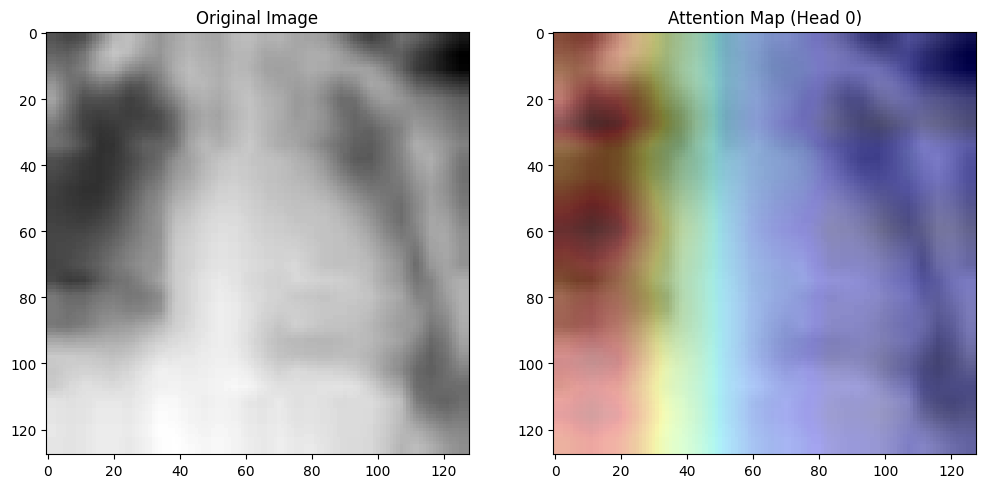

Attention map shape: torch.Size([16, 16])


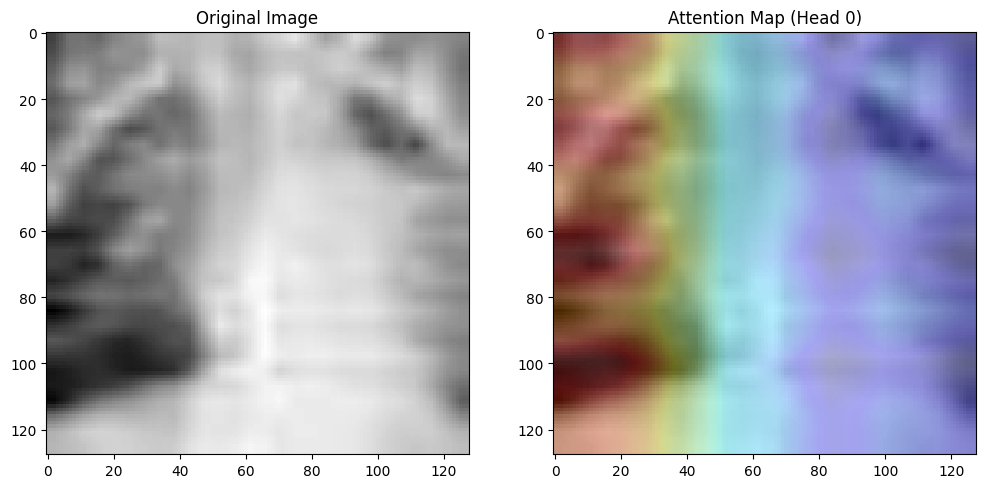

Attention map shape: torch.Size([16, 16])


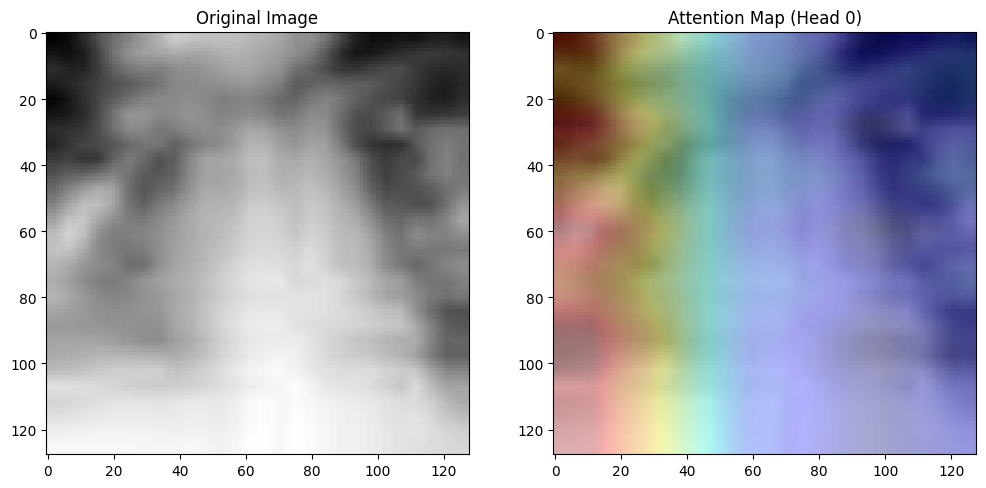

Attention map shape: torch.Size([16, 16])


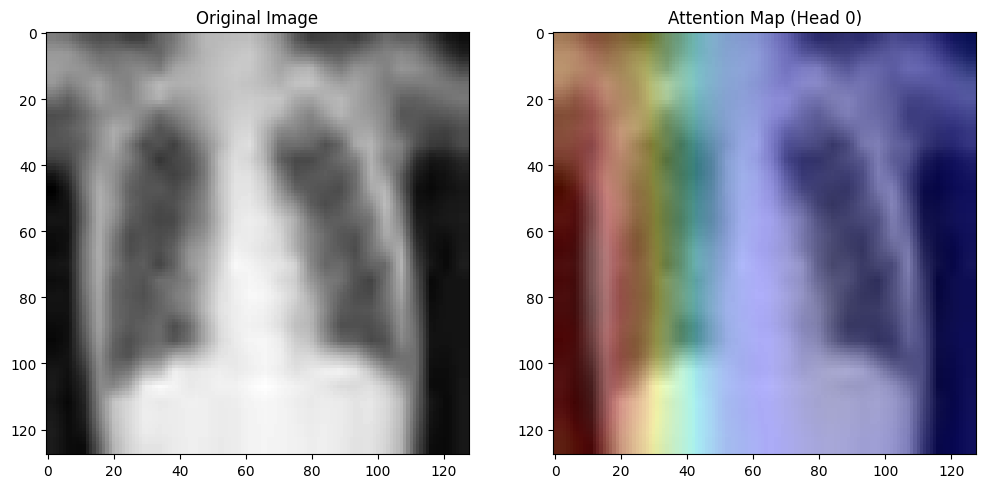

In [18]:
# Function to register a hook and capture attention weights
def get_attention_map(model, image_tensor):
    attention_maps = []

    def hook_fn(module, input, output):
        # Append attention weights if available in output
        attention_maps.append(output[1])  # Assuming output[1] contains the attention weights in each layer

    # Register hooks for each transformer layer's self-attention
    handles = []
    for layer in model.transformer_layers:
        handle = layer.self_attn.register_forward_hook(hook_fn)
        handles.append(handle)

    # Forward pass to activate the hooks
    model.eval()
    with torch.no_grad():
        model(image_tensor)

    # Remove hooks
    for handle in handles:
        handle.remove()

    # Return attention maps from the last layer for visualization
    if attention_maps:
        return attention_maps[-1].squeeze(0)  # Use only the last layer's attention map
    else:
        raise ValueError("Attention maps not captured. Check if hooks were placed correctly.")

# Function to visualize the attention map overlay on the input image
def plot_attention_map(image, attention_map, head=0):
    # Print shape for verification
    print("Attention map shape:", attention_map.shape)

    # Average over heads if multiple heads are present
    if attention_map.dim() == 3:  # (num_heads, seq_len, seq_len)
        attn = attention_map[head] if attention_map.size(0) > 1 else attention_map[0]
    elif attention_map.dim() == 2:  # Single-head or pre-averaged
        attn = attention_map
    else:
        raise ValueError("Unexpected attention map dimensions. Expected 2D or 3D tensor.")

    # Normalize directly without reshaping
    attn = (attn - attn.min()) / (attn.max() - attn.min() + 1e-5)

    # Resize to match the image size (assuming image is 128x128)
    attn_resized = F.interpolate(attn.unsqueeze(0).unsqueeze(0), size=(128, 128), mode="bilinear").squeeze()

    # Plot the original image with the attention map overlay
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image.squeeze(), cmap="gray")
    ax[0].set_title("Original Image")

    ax[1].imshow(image.squeeze(), cmap="gray")
    ax[1].imshow(attn_resized.cpu(), cmap="jet", alpha=0.3)  # Overlay with transparency
    ax[1].set_title(f"Attention Map (Head {head})")
    plt.show()

# Iterate through a few samples from the validation set
num_images = 4  # Set the number of images you'd like to display
images_shown = 0

for sample_image, _ in val_loader:
    if images_shown >= num_images:
        break  # Stop once we've displayed the desired number of images

    sample_image = sample_image[0].unsqueeze(0).to(device)  # Select one image from the batch

    try:
        # Get the attention map for the sample image
        attention_map = get_attention_map(model, sample_image)

        # Plot the attention map overlay on the original image
        plot_attention_map(sample_image.cpu().squeeze(0), attention_map)  # Remove batch dimension for plotting

        images_shown += 1  # Increment the counter
    except ValueError as e:
        print(f"Error with image {images_shown}: {e}")

### Cell 17: Hybrid - Plots
This cell calls the `plot_metrics` and `plot_confusion_matrix` functions to visualize the model's performance across epochs and displays the final confusion matrix. The trained model is then saved to a file for later use.

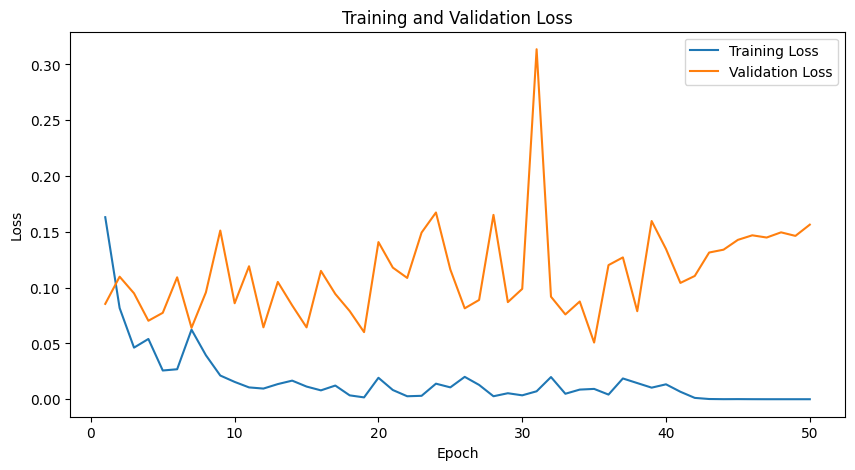

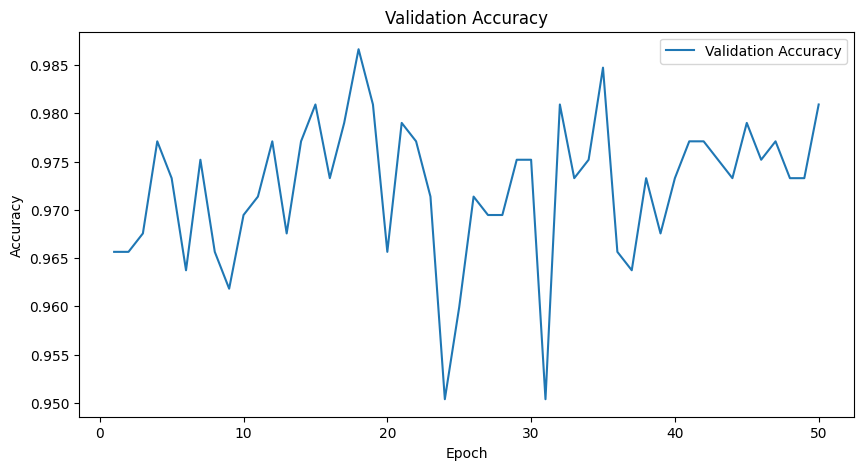

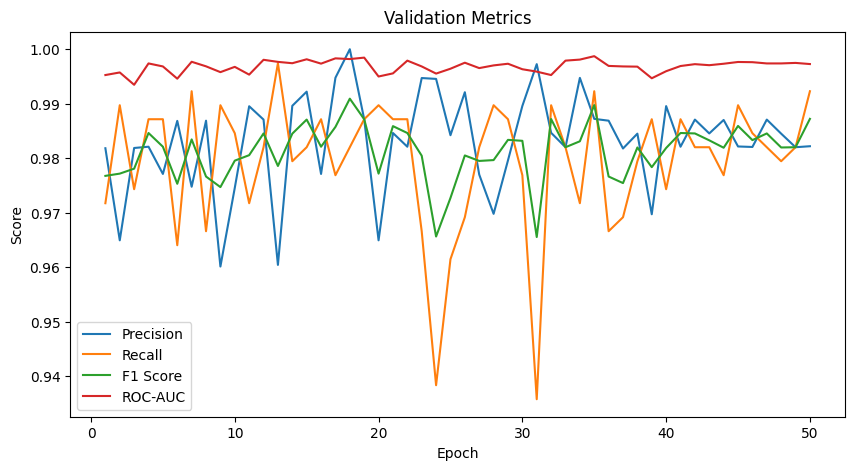

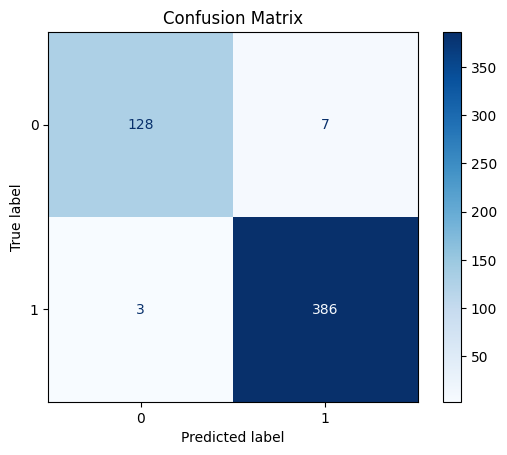

In [19]:
# Plot metrics
plot_metrics(train_losses, val_losses, val_accuracies, val_precisions, val_recalls, val_f1s, val_roc_aucs)

# Plot confusion matrix
plot_confusion_matrix(val_loader, model, device)

# Save the trained model
torch.save(model.state_dict(), "pneumonia_hybrid.pth")